# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [12]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

# colors = cycle(mcolors.XKCD_COLORS.keys())
colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

## Functions

In [37]:
def get_cluster_trees_from_h5file(h5_file, cluster_similarity_threshold = .4, nskip = 10, part_min = 0):
    clusters = []
    with h5py.File(h5_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        for tg in time_grp_list:
            clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
            clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
            clusters += [clust_grp]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    return trees

def get_lifetimes(branch_roots, min_time = 0, min_length = 0):
    lifetime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        lifetime_list += [l_branch[0].time-l_branch[-1].time]

    return lifetime_list

def plot_branches(axarr, branch_roots, window_size=10):
    time_list = []
    for root in branch_roots:
        l_branch = root.get_largest_branch()
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for i, clust in enumerate(l_branch):
            size_arr[i] = len(clust.part_ids)
            time_arr[i] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=1)
        time_list += [time_arr[0]-time_arr[-1]]
    return time_list

## Plots

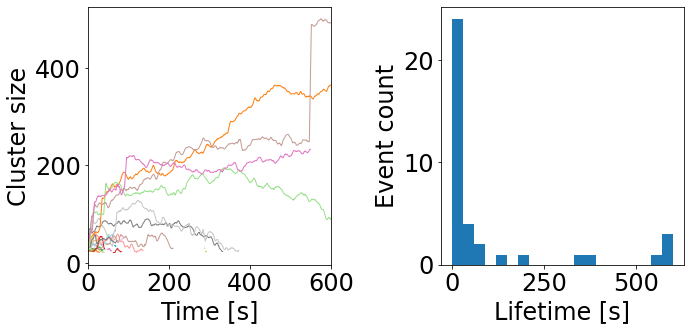

In [63]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40
# tableau10_colors = iter(cycle(plt.cm.tab10.colors))


data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []

    for tg in time_grp_list:
        clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
        clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

fig, axarr = plt.subplots(1,2, figsize=(10, 5))
from scipy.ndimage.filters import uniform_filter1d
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)


merge_events = 0
time_list = []
for tree in trees:
    if len(tree.clusters) < 10:
        continue
    tree.update_branch_roots()
    branch_roots = tree.get_branch_roots()
    merge_events += len(branch_roots)
    time_list += plot_branches(axarr[0], branch_roots)

_ = axarr[0].set_xlabel('Time [s]')
_ = axarr[0].set_ylabel('Cluster size')
_ = axarr[0].set_xlim(0, 600)

_ = axarr[1].hist(time_list, bins=20)
_ = axarr[1].set_ylabel('Event count')
_ = axarr[1].set_xlabel('Lifetime [s]')
fig.tight_layout()

[None, None, None, None, None, None, None, None]

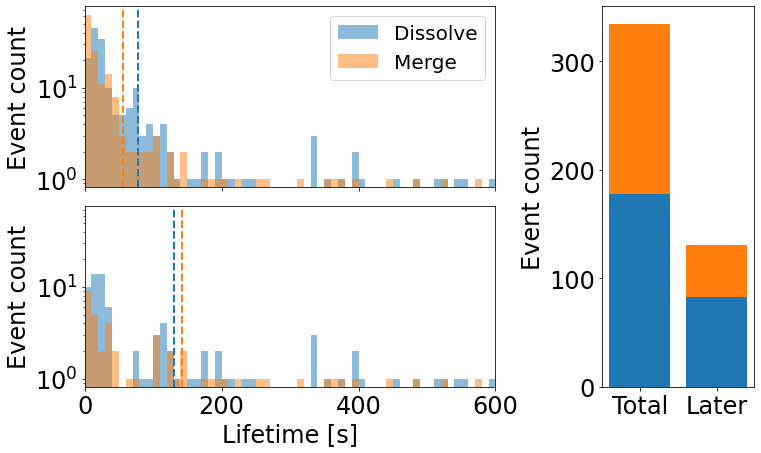

In [61]:
# Total events
end_time = 600
min_time = 0
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

merge_lifetime_total_list = []
dissolve_lifetime_total_list = []
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_total_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_total_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

min_time = 100
merge_lifetime_later_list = []
dissolve_lifetime_later_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_later_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_later_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)


In [ ]:

gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(12, 7))
axarr = [fig.add_subplot(gs[0, 0:2])]

fig.subplots_adjust(hspace=0.1, wspace=0.7)
axarr += [fig.add_subplot(gs[1, :2], sharex=axarr[0], sharey=axarr[0]), fig.add_subplot(gs[:, 2:])]

_ = axarr[0].hist(dissolve_lifetime_total_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[0].hist(merge_lifetime_total_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[0].axvline(np.mean(dissolve_lifetime_total_list), color='C0', linestyle='--')
_ = axarr[0].axvline(np.mean(merge_lifetime_total_list), color='C1', linestyle='--')
_ = axarr[0].legend()
_ = axarr[0].set_yscale('log')  
_ = axarr[0].set_ylabel('Event count')
_ = axarr[0].set_xlim(0, 600)


_ = axarr[1].set_ylabel('Event count')
_ = axarr[1].hist(dissolve_lifetime_later_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[1].hist(merge_lifetime_later_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[1].axvline(np.mean(dissolve_lifetime_later_list), color='C0', linestyle='--')
_ = axarr[1].axvline(np.mean(merge_lifetime_later_list), color='C1', linestyle='--')
_ = axarr[1].set_xlabel('Lifetime [s]')

_ = axarr[2].bar(['Total', 'Later'], [np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:blue', 'tab:blue'])
_ = axarr[2].bar(['Total', 'Later'], [np.size(merge_lifetime_total_list), np.size(merge_lifetime_later_list)], bottom=[np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:orange', 'tab:orange'])
_ = axarr[2].set_ylabel('Event count')

plt.setp(axarr[0].get_xticklabels(), visible=False)
# axarr[0].label_outer()
            

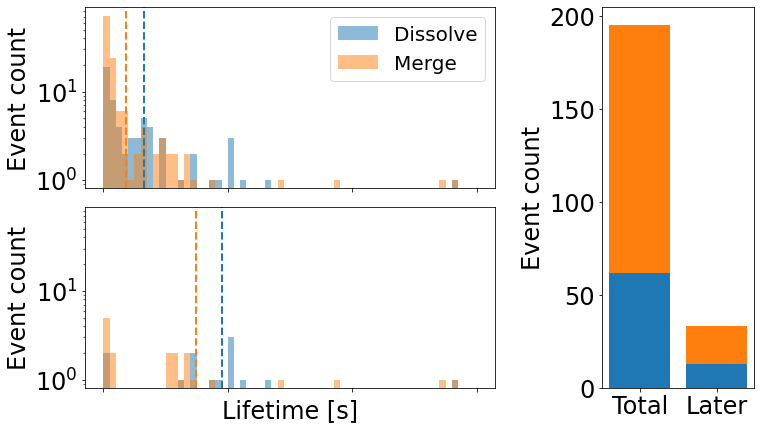

In [35]:
# Total events
end_time = 600
min_time = 0
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke30_Pin3.0um/"

merge_lifetime_total_list = []
dissolve_lifetime_total_list = []
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_total_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_total_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

min_time = 100
merge_lifetime_later_list = []
dissolve_lifetime_later_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_later_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_later_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)
            
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(12, 7))
axarr = [fig.add_subplot(gs[0, 0:2])]
axarr += [fig.add_subplot(gs[1, :2], sharex=axarr[0], sharey=axarr[0]), fig.add_subplot(gs[:, 2:])]
fig.subplots_adjust(hspace=0.1, wspace=0.7)

_ = axarr[0].hist(dissolve_lifetime_total_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[0].hist(merge_lifetime_total_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[0].axvline(np.mean(dissolve_lifetime_total_list), color='C0', linestyle='--')
_ = axarr[0].axvline(np.mean(merge_lifetime_total_list), color='C1', linestyle='--')
_ = axarr[0].legend()
_ = axarr[0].set_yscale('log')  
_ = axarr[0].set_ylabel('Event count')

_ = axarr[1].set_ylabel('Event count')
_ = axarr[1].hist(dissolve_lifetime_later_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[1].hist(merge_lifetime_later_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[1].axvline(np.mean(dissolve_lifetime_later_list), color='C0', linestyle='--')
_ = axarr[1].axvline(np.mean(merge_lifetime_later_list), color='C1', linestyle='--')
_ = axarr[1].set_xlabel('Lifetime [s]')

_ = axarr[2].bar(['Total', 'Later'], [np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:blue', 'tab:blue'])
_ = axarr[2].bar(['Total', 'Later'], [np.size(merge_lifetime_total_list), np.size(merge_lifetime_later_list)], bottom=[np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:orange', 'tab:orange'])
_ = axarr[2].set_ylabel('Event count')


_ = axarr[0].set_xticklabels([])    


In [36]:
# Total events
end_time = 600
min_time = 0
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"

merge_lifetime_total_list = []
dissolve_lifetime_total_list = []
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_total_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_total_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

min_time = 100
merge_lifetime_later_list = []
dissolve_lifetime_later_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_later_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_later_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(12, 7))
axarr = [fig.add_subplot(gs[0, 0:2])]

fig.subplots_adjust(hspace=0.1, wspace=0.7)
axarr += [fig.add_subplot(gs[1, :2], sharex=axarr[0], sharey=axarr[0]), fig.add_subplot(gs[:, 2:])]

_ = axarr[0].hist(dissolve_lifetime_total_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[0].hist(merge_lifetime_total_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[0].axvline(np.mean(dissolve_lifetime_total_list), color='C0', linestyle='--')
_ = axarr[0].axvline(np.mean(merge_lifetime_total_list), color='C1', linestyle='--')
_ = axarr[0].legend()
_ = axarr[0].set_yscale('log')  
_ = axarr[0].set_ylabel('Event count')


_ = axarr[1].set_ylabel('Event count')
_ = axarr[1].hist(dissolve_lifetime_later_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[1].hist(merge_lifetime_later_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[1].axvline(np.mean(dissolve_lifetime_later_list), color='C0', linestyle='--')
_ = axarr[1].axvline(np.mean(merge_lifetime_later_list), color='C1', linestyle='--')
_ = axarr[1].set_xlabel('Lifetime [s]')

_ = axarr[2].bar(['Total', 'Later'], [np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:blue', 'tab:blue'])
_ = axarr[2].bar(['Total', 'Later'], [np.size(merge_lifetime_total_list), np.size(merge_lifetime_later_list)], bottom=[np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:orange', 'tab:orange'])
_ = axarr[2].set_ylabel('Event count')

plt.setp(axarr[0].get_xticklabels(), visible=False)
# axarr[0].label_outer()
            

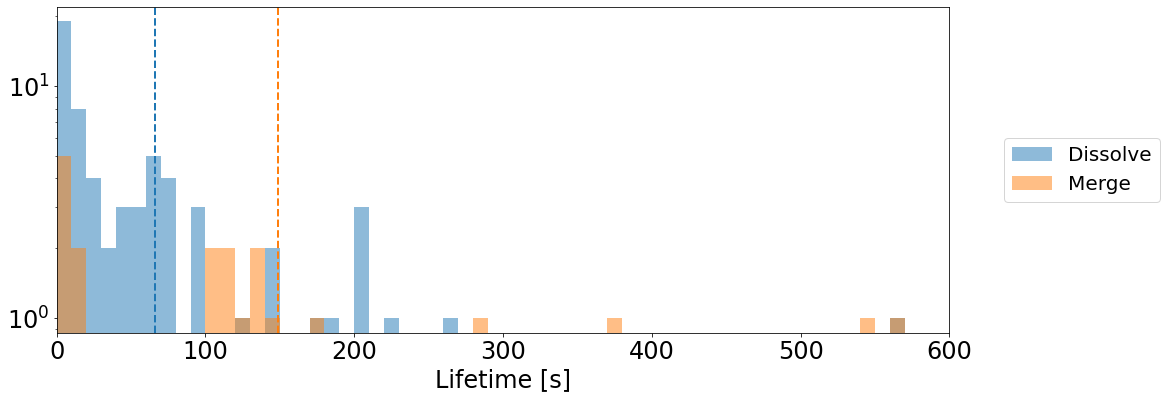

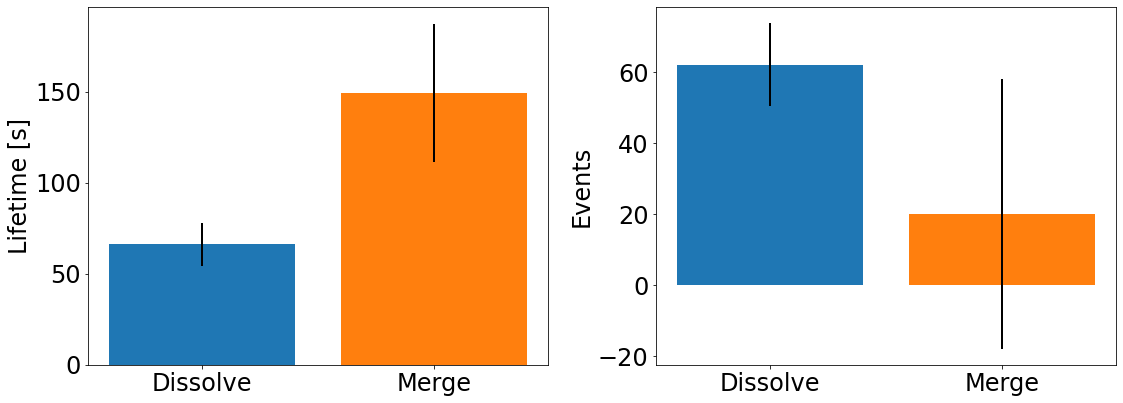

In [11]:
# Total events
end_time = 600
min_time = 100
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke30_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr.hist(merge_lifetime_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
_ = fig.tight_layout()

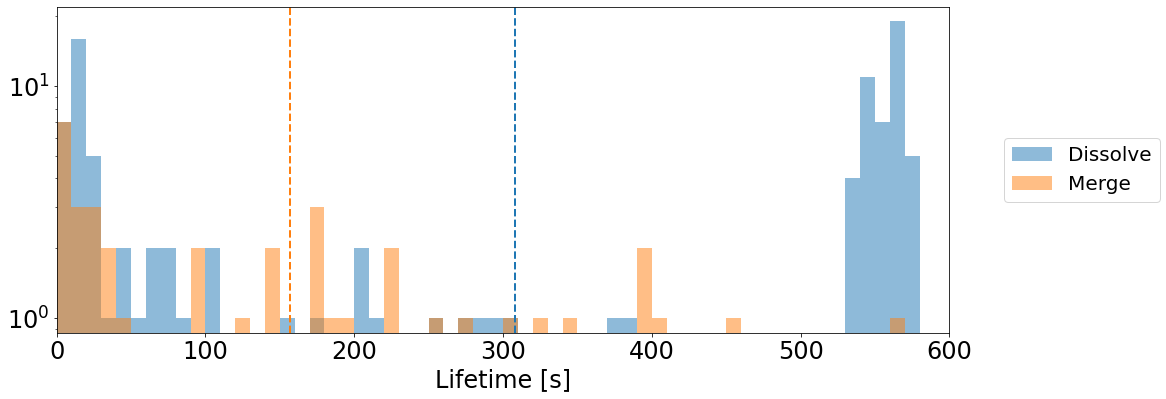

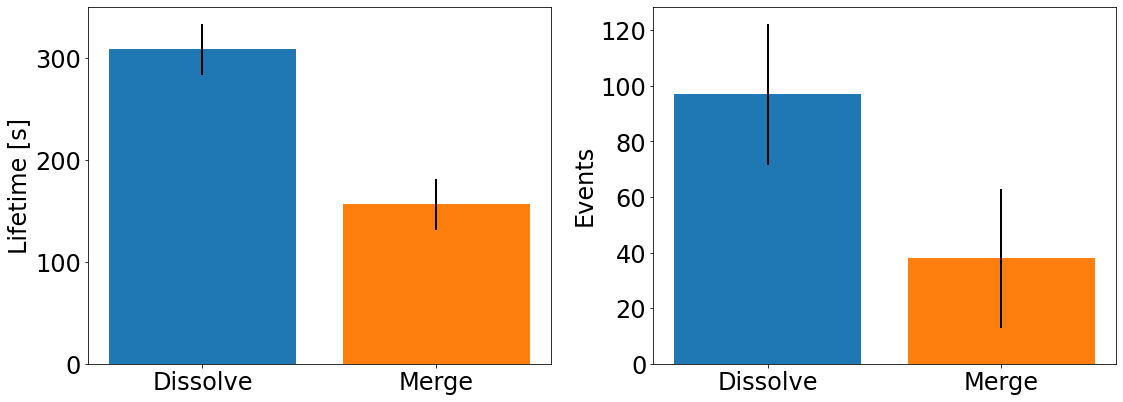

In [29]:
end_time = 600
min_time = 100
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke30_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr.hist(merge_lifetime_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
_ = fig.tight_layout()

# Old

(array([342.,  18.,   5.,   2.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.   ,  29.975,  59.95 ,  89.925, 119.9  , 149.875, 179.85 ,
        209.825, 239.8  , 269.775, 299.75 , 329.725, 359.7  , 389.675,
        419.65 , 449.625, 479.6  , 509.575, 539.55 , 569.525, 599.5  ]),
 <BarContainer object of 20 artists>)

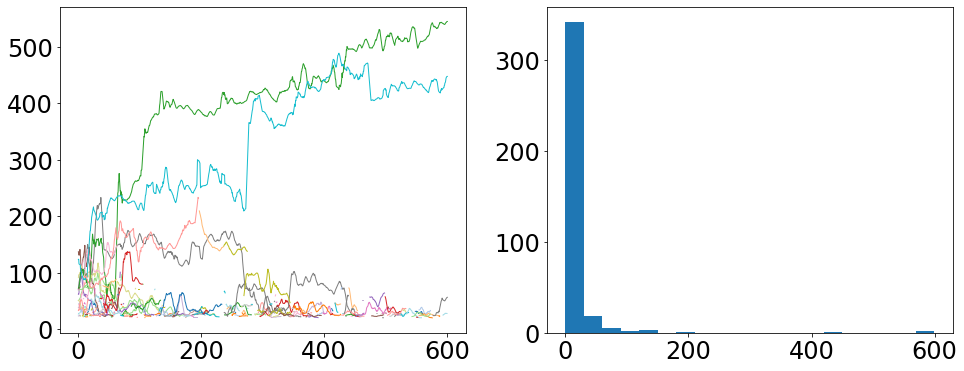

In [20]:
fig, axarr = plt.subplots(1,2, figsize=(16, 6))
from scipy.ndimage.filters import uniform_filter1d
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke30_Pin3.0um/s1"

trees = get_cluster_trees_from_h5file(sim_path / 'analysis/cluster_analysis.h5')

merge_events = 0
time_list = []
for tree in trees:
    if len(tree.clusters) < 10:
        continue
    branch_roots = tree.get_branch_roots()
    merge_events += len(branch_roots)
    time_list += plot_branches(axarr[0], branch_roots)

axarr[1].hist(time_list, bins=20)

(array([3.60e+03, 5.00e+02, 1.83e+02, 8.80e+01, 4.80e+01, 3.60e+01,
        1.60e+01, 2.30e+01, 1.30e+01, 8.00e+00, 8.00e+00, 4.00e+00,
        3.00e+00, 2.00e+00, 7.00e+00, 5.00e+00, 2.00e+00, 2.00e+00,
        3.00e+00, 8.00e+00, 6.00e+00, 2.00e+00, 4.00e+00, 0.00e+00,
        1.00e+00, 3.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 3.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 4.00e+00, 3.30e+01]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300., 315.,
        330., 345., 360., 375., 390., 405., 420., 435., 450., 465., 480.,
        495., 510., 525., 540., 555., 570., 585., 600.]),
 <BarContainer object of 40 artists>)

Text(0.5, 0, 'Lifetime [s]')

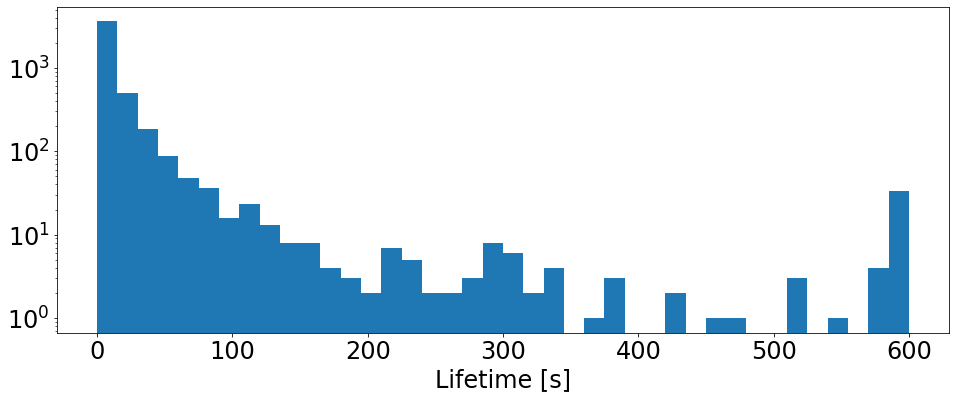

In [14]:
end_time = 600 # seconds, If condensate makes it to the end, don't count it

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_events = 0
lifetime_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            lifetime_list += [mb[0].time-mb[-1].time]
        tree.update_branch_roots()
        branch_roots = tree.get_branch_roots()
        merge_events += len(branch_roots) - 1
        lifetime_list += get_lifetimes(branch_roots)

fig, axarr = plt.subplots(1,1, figsize=(16, 6))
axarr.hist(lifetime_list, bins=40)
axarr.set_xlabel('Lifetime [s]')
axarr.set_yscale('log')

(array([3.373e+03, 3.210e+02, 1.210e+02, 5.500e+01, 3.200e+01, 2.200e+01,
        1.000e+01, 1.400e+01, 7.000e+00, 5.000e+00, 5.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 6.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 3.200e+01]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300., 315.,
        330., 345., 360., 375., 390., 405., 420., 435., 450., 465., 480.,
        495., 510., 525., 540., 555., 570., 585., 600.]),
 <BarContainer object of 40 artists>)

Text(0.5, 0, 'Lifetime [s]')

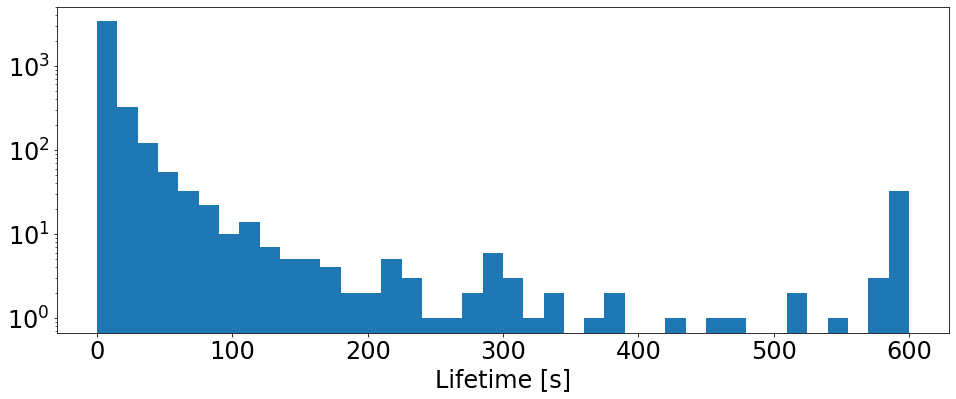

In [27]:
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
axarr.hist(lifetime_list, bins=40)
axarr.set_xlabel('Lifetime [s]')
axarr.set_yscale('log')

<BarContainer object of 2 artists>

Text(0, 0.5, 'Lifetime [s]')

<BarContainer object of 2 artists>

Text(0, 0.5, 'Events')

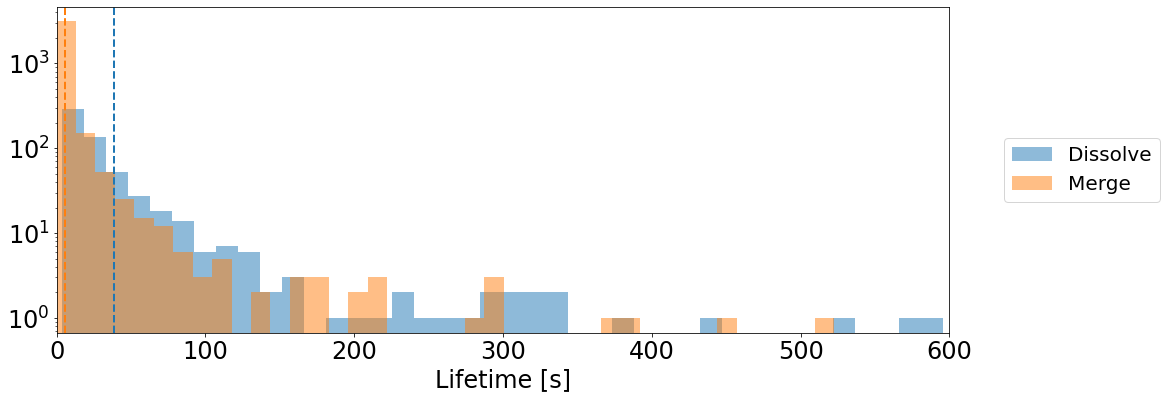

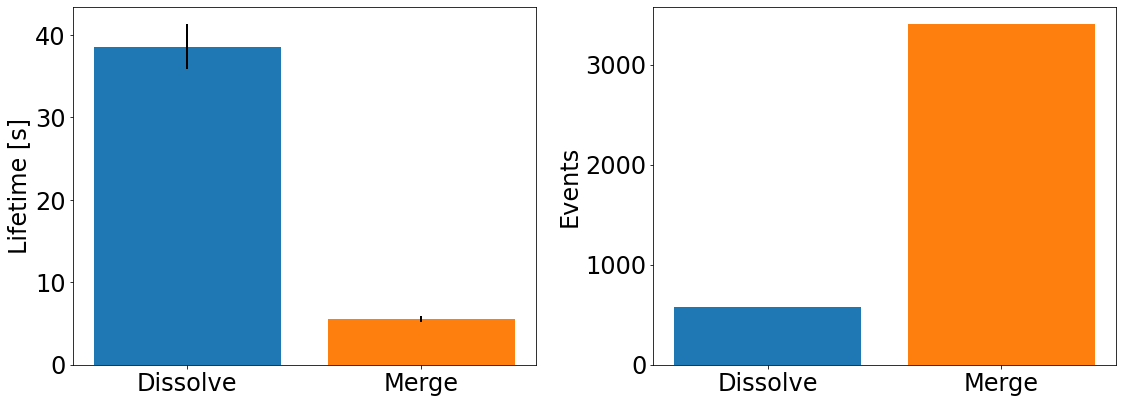

In [18]:
end_time = 600

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:])
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
fig.tight_layout()

<BarContainer object of 2 artists>

Text(0, 0.5, 'Lifetime [s]')

<BarContainer object of 2 artists>

Text(0, 0.5, 'Events')

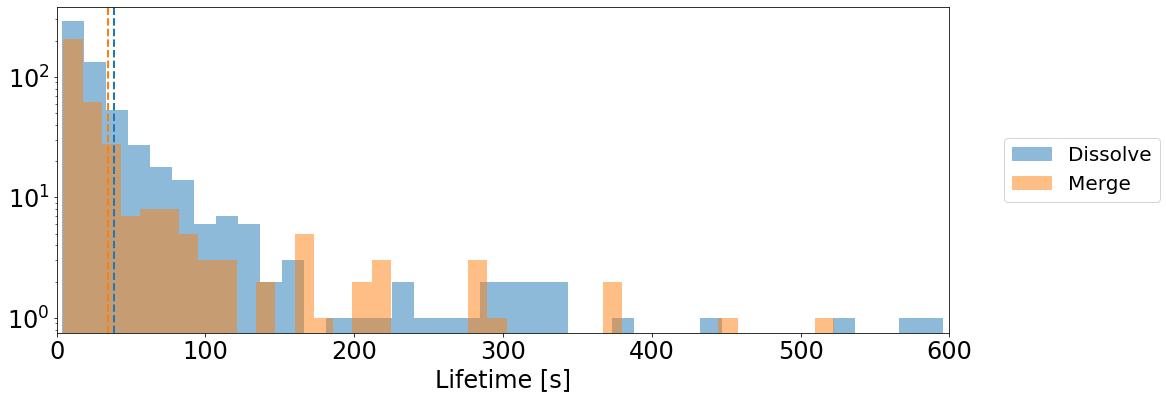

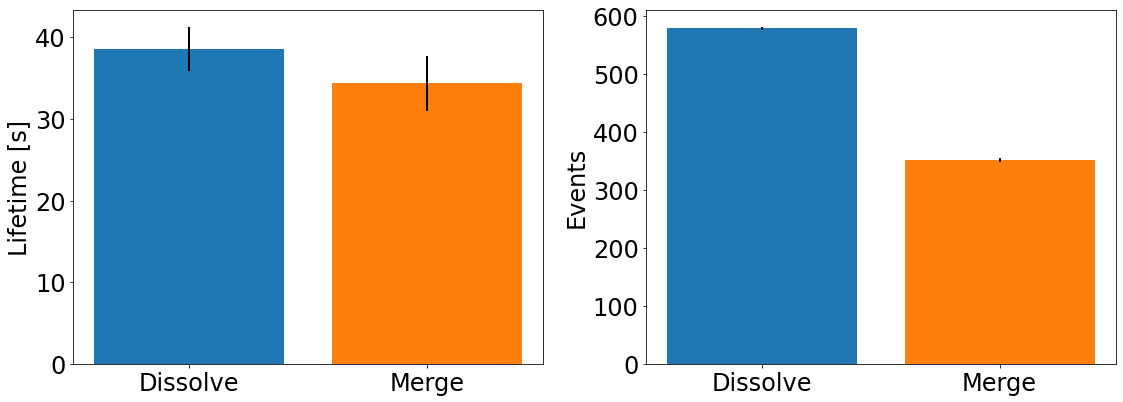

In [19]:
end_time = 600
min_time = 100
min_length = 10

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
axarr[0].set_ylabel('Lifetime [s]')

axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
axarr[1].set_ylabel('Events')
fig.tight_layout()

<BarContainer object of 2 artists>

Text(0, 0.5, 'Lifetime [s]')

<BarContainer object of 2 artists>

Text(0, 0.5, 'Events')

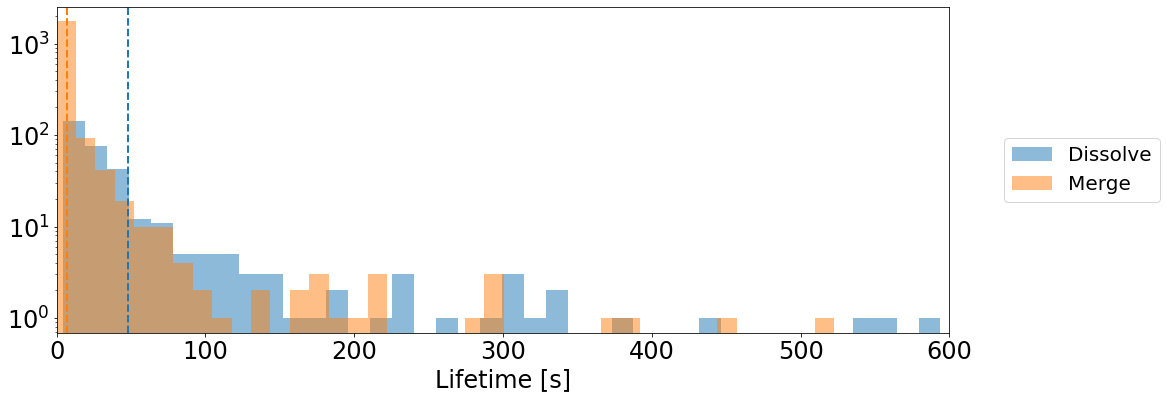

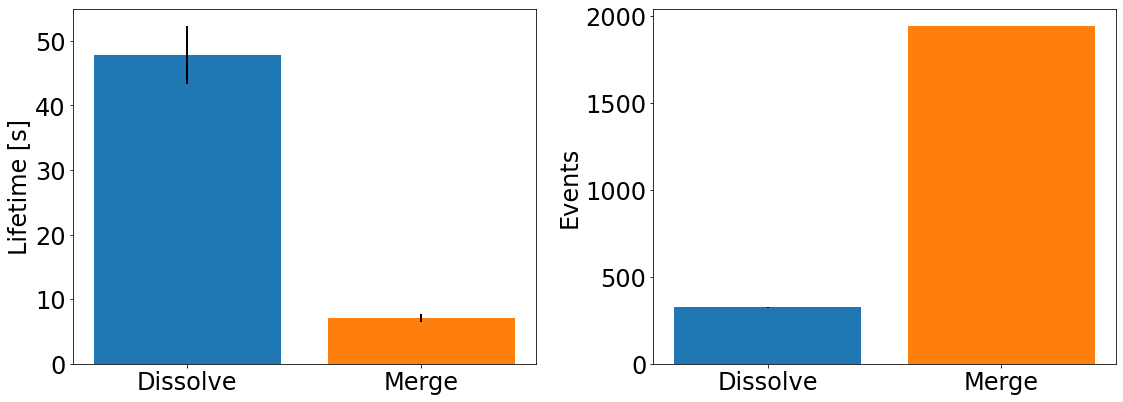

In [20]:
end_time = 600
min_time = 100
min_length = 10

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5', part_min=30)
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:])
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
axarr[0].set_ylabel('Lifetime [s]')

axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
axarr[1].set_ylabel('Events')
fig.tight_layout()

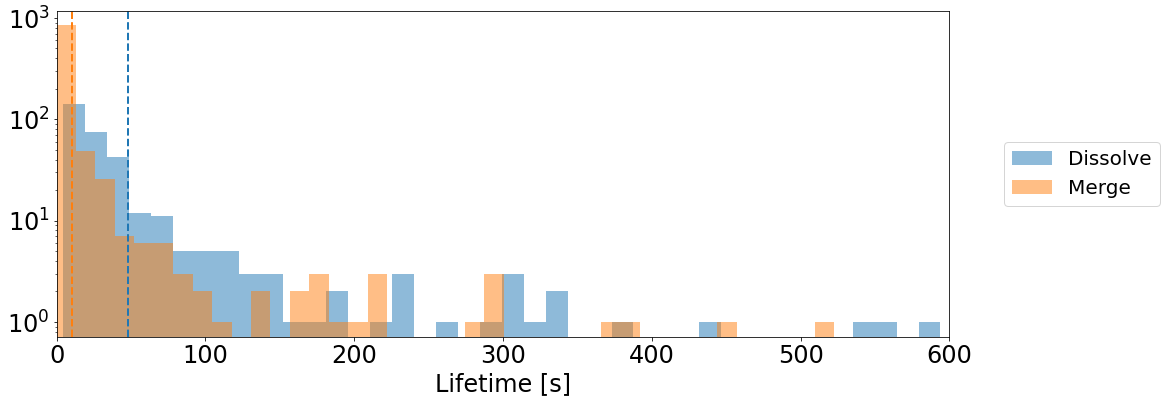

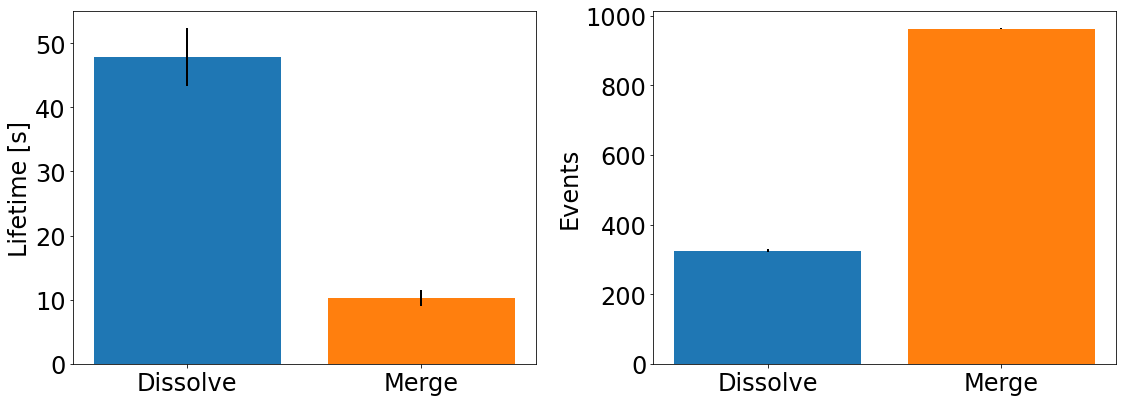

In [21]:
end_time = 600
min_time = 100
min_length = 10

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5', part_min=30)
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:], min_time=min_time)
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
_ = fig.tight_layout()

<BarContainer object of 2 artists>

Text(0, 0.5, 'Lifetime [s]')

<BarContainer object of 2 artists>

Text(0, 0.5, 'Events')

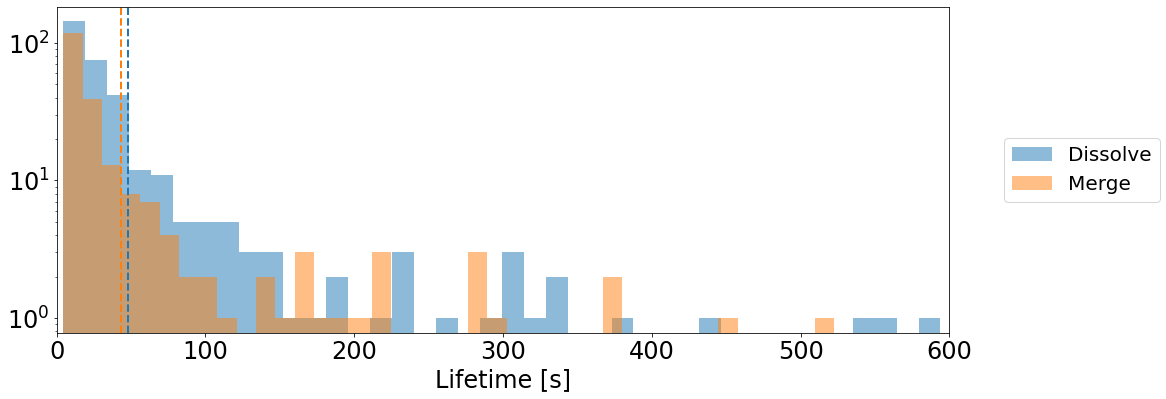

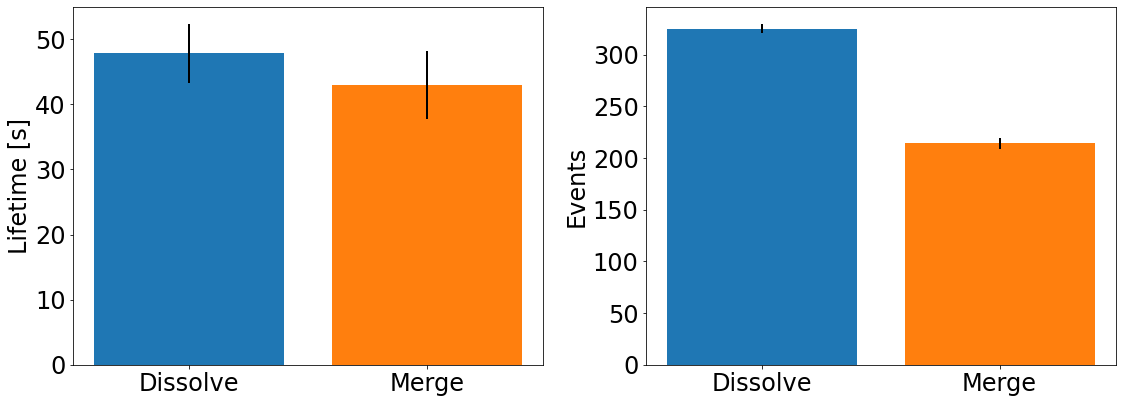

In [17]:
end_time = 600
min_time = 100
min_length = 10

data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks800/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5', part_min=30)
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
_ = fig.tight_layout()

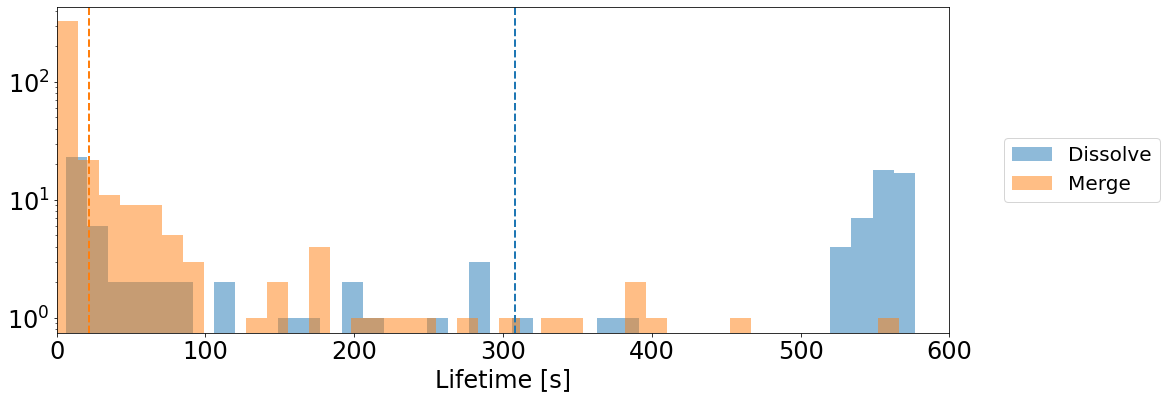

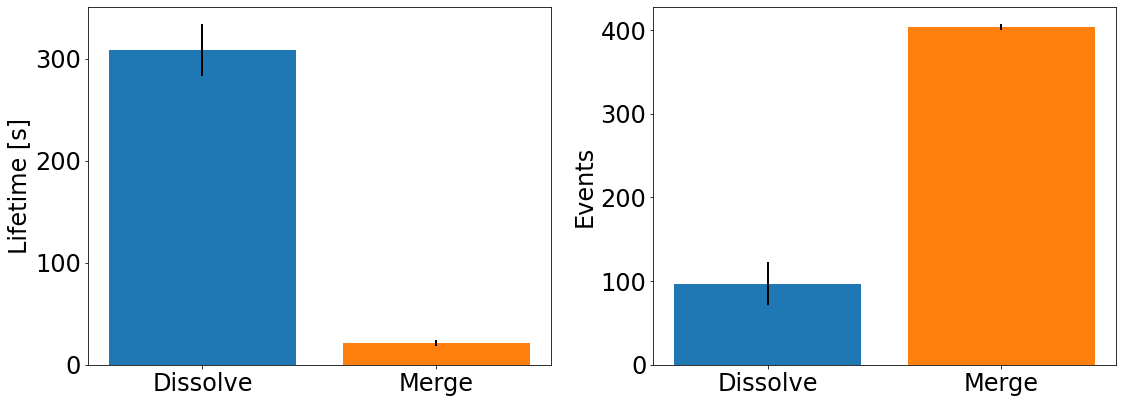

In [ ]:
end_time = 600

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke100_Pin3.0um/"
merge_lifetime_list = []
dissolve_lifetime_list = []

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 10:
            continue
        if tree.clusters[0].time < end_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_list += get_lifetimes(branch_roots[1:])
            
fig, axarr = plt.subplots(1,1, figsize=(16, 6))
_ = axarr.hist(dissolve_lifetime_list, bins=40, label='Dissolve', alpha=.5)
_ = axarr.hist(merge_lifetime_list, bins=40, label='Merge', alpha=.5)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr.axvline(np.mean(dissolve_lifetime_list), color='C0', linestyle='--')
_ = axarr.axvline(np.mean(merge_lifetime_list), color='C1', linestyle='--')

_ = axarr.set_xlabel('Lifetime [s]')
_ = axarr.set_yscale('log')
_ = axarr.set_xlim(0, 600)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].bar(['Dissolve', 'Merge'], [np.mean(dissolve_lifetime_list), np.mean(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[0].set_ylabel('Lifetime [s]')

_ = axarr[1].bar(['Dissolve', 'Merge'], [np.size(dissolve_lifetime_list), np.size(merge_lifetime_list)], yerr=[stats.sem(dissolve_lifetime_list), stats.sem(merge_lifetime_list)], color=['C0', 'C1'])
_ = axarr[1].set_ylabel('Events')
fig.tight_layout()